In [4]:
import numpy as np
from scipy import stats
from scipy.stats import norm

import seaborn as sns
import plotly.graph_objects as go

from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate

import pandas as pd
import yfinance as yf
import bt
import matplotlib.pyplot as plt
%matplotlib inline
plt.get_backend()

'module://matplotlib_inline.backend_inline'

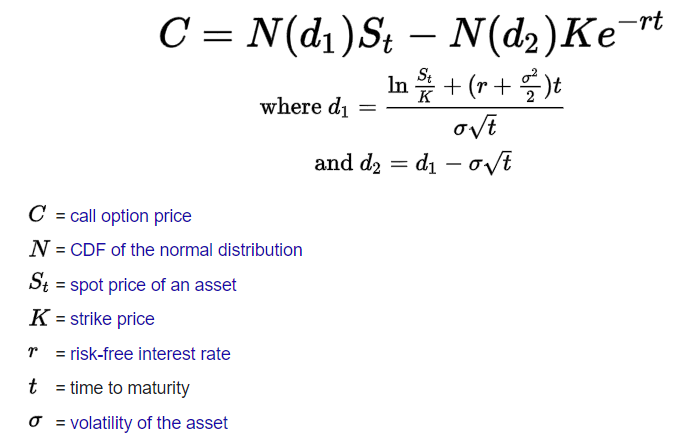

In [5]:
ticker_list = pd.read_csv('bats_symbols_bzx.csv')['Symbols']

# Need to have a default strike price before the callback function runs in order to display the default inputs; 
#prices is referenced in id='strike_price'

default_ticker = 'SPY'
last_spot_price=100

In [318]:
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.COSMO])

app.layout = html.Div([
    dbc.Tabs([
        dbc.Tab([
        dbc.Row([
        dbc.Col([
        dbc.Label('Select Asset'),
        dcc.Dropdown(id='stock_dropdown',
                 value=default_ticker,
                 options=[{'label': stock, 'value': stock}
                          for stock in ticker_list])
        ], md=3,lg=3)
    ]), #Row Close
        dbc.Row([
        dbc.Col([
            html.Br(),
            dbc.Label('Select number of days used to calculate volatility'),
            dcc.Slider(id='vol_days_slider',
               min=0, max=3650, step=1, included=False,
               value=252,
               marks={days: str(days) for days in range(0, 365*11, 365)})
                ]) 
    ]),
    dbc.Row(
        dbc.Col(id='current_price_output')
    ),
    dbc.Row([
        dbc.Col([
            dbc.Label('Select Strike Price'),
            dbc.Input(id='strike_price', type='number')
        ], md=3,lg=3)
        ]),
    dbc.Row([
    dbc.Label('Select calendar days to expiration'),
    dcc.Slider(id='expiry_days_slider',
               min=0, max=365, step=1, included=False,
               value=90,
               marks={days: str(days) for days in range(0, 370, 10)})
    ]),
    dcc.Graph(id='black_scholes_chart')
        ], label='Option Prices'), # Tab close
        
        dbc.Tab([
            dbc.Row([
                dbc.Col([
                    dbc.Label('Select Asset'),
                    dcc.Dropdown(id='stock_dropdown2',
                    value=default_ticker,
                    options=[{'label': stock, 'value': stock}
                          for stock in ticker_list])
                ],md=3, lg=3),
                dbc.Col([
                    dbc.Label('Number of Years to Simulate'),
                    dbc.Input(id='monte_carlo_years', type='number', value=10)
                ], md=3, lg=3)
            ]), # Row close
            dbc.Row([
                dcc.Graph(id='monte_carlo_chart')
            ])
        ], label='Monte Carlo Simulator') # Tab close
    ]) # Tabs close
])


# This is a chained callback that makes the current price of the selected stock the default value of the Strike Price
# See: https://dash.plotly.com/basic-callbacks
@app.callback(Output('strike_price', 'value'),
              Input('stock_dropdown', 'value'))
def default_strike_price(selected_stock):
              prices = yf.Ticker(selected_stock).history(period='100y', interval='1d')
              last_spot_price = np.round(prices['Close'][-1],0)
              return last_spot_price

# Option Price Callback Function           
@app.callback(Output('black_scholes_chart', 'figure'),
              Output('current_price_output', 'children'),
              Input('stock_dropdown', 'value'),
              Input('expiry_days_slider', 'value'),
              Input('strike_price', 'value'),
              Input('vol_days_slider', 'value'))
def black_scholes_chart(asset, expiry_days, strike_price, vol_days):
    ### Placeholder for State input ###
    #if not n_clicks:
    #    raise PreventUpdate
        
    prices = yf.Ticker(asset).history(period='100y', interval='1d')
    changes = prices.pct_change()
    
    last_spot_price = np.round(prices['Close'][-1],0)
    
    K = strike_price  # strike price from user input
    St = np.arange(np.round(K*0.5,0), np.round(K*2,0))      # Spot Price Range
    r = 0.01      # Risk Free Annual Interest Rate
    sigma = changes['Close'][-1*vol_days:-1].std()*np.sqrt(252)   # Annual Volatility
    t = expiry_days/365    # Time to Maturity in Years
    
    # Call Price Function (Black Scholes Model)
    def black_scholes(K,St,r,sigma,t):
        d1 = (np.log(St/K) + (r + sigma**2/2)*t)/(sigma*t**0.5)
        d2 = d1 - sigma*(t**0.5)
        C = norm.cdf(d1)*St - norm.cdf(d2)*K*np.exp(-r*t)
        return C

    fig = go.Figure()
    fig.add_scatter(x=St, y=black_scholes(K,St,r,sigma,t), name='Spot Price')
    fig.add_vline(last_spot_price, name='Current Price', annotation_text='Current Spot Price')
    fig.layout.title = f'Call Option Price versus Spot Price: {asset} @ Strike Price = {strike_price}'
    fig.layout.xaxis.title = 'Spot Price'
    fig.layout.yaxis.title = 'Call Option Price'
    fig.update_xaxes(tickformat='$,')
    fig.update_yaxes(tickformat='$,')
    return fig, f'Last Close price of {asset}: {last_spot_price}'


# Monte Carlo Chart
@app.callback(Output('monte_carlo_chart', 'figure'),             
              Input('stock_dropdown2', 'value'),
              Input('monte_carlo_years', 'value'))

def monte_carlo(asset, years):
    prices = yf.Ticker(asset).history(period='100y', interval='1d')['Close']
    changes = prices.pct_change()
    
    mu = np.mean(changes)
    std = np.std(changes)
    T = years*252
    N_steps = years
    step = int(np.round(T/N_steps,0))
    N_sims = 1000

    def forecast(mu, std, T):

        snapshots = []
        min_forecasts = []
        year_end_forecasts = []
        
        fig = go.Figure()
        S0 = 10000 # Starting Value
        
        for i in range(N_sims):
            rand_rets = np.random.normal(mu, std, T) + 1
            forecasted_values = S0*(rand_rets).cumprod()
            
            # Get portfolio value snapshots throughout year and insert "0" to plot starting portfolio value
            snapshot_prices = [forecasted_values[item] for item in np.arange(step-1, T, step)]
            snapshots.append([0] + snapshot_prices)
            
            # Get minimum value, final value
            min_forecasts.append(forecasted_values.min())
            year_end_forecasts.append(forecasted_values[-1])
            
        return snapshots
            
    # Call forecast function and save output as np.array
    snapshots = np.array(forecast(mu, std, T))
    
    # Calculate and plot each percentile line
    percentile_list = [5, 10, 20, 50, 80, 90, 95]
    
    fig = go.Figure()
    for percentile in percentile_list:
        fig.add_scatter(x=list(np.arange(0,years+1,1)), 
                        y=np.percentile(snapshots, percentile, axis=0), 
                        name=f'{percentile}th Percentile')
    fig.layout.title = f'{N_sims} Simulations of {asset} over {years} years'
    fig.layout.xaxis.title = 'Time (Years)'
    fig.layout.yaxis.title = 'Portfolio Value'
    fig.update_yaxes(tickformat='$,')
    return fig
        
app.run_server(mode='inline', port=8043)

1. Bring in daily price data for selected stock.

2. Calculate volatility using Garch (have inputs for coefficients)

1. def Black Scholes formula for Call:
    a. calculate d1 and d2
    b. calculate N(d1) and N(d2); probability that a random variable taken from a normal distribution is less than or equal to d1 or d2.
    c. Calculate C
2. def Black Scholes formula for Put:
    a. etc, etc.

3. Add an input that chooses the time period over which to calculate the volatility of the asset
4. Apply a Garch(1,1,1) model to calculate volatility
5. Add an ARIMA model to predict stock price movement

5. Calculate the fair value of the option based on historical % returns:
    a. Calculate what the percent chance is of passing the strike price (e.g. VAR80)
    b. Calculate the CVAR for that % VAR (e.g. CVAR80)
